In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

In [ ]:
# Load the iris dataset
iris = load_iris()
X = iris.data             # Extract the features (sepal length, sepal width, petal length, petal width)
y = iris.target           # Extract the labels (0, 1, 2 for the three Iris species)

scaler = StandardScaler()  # Standard scaler to normalize the features
X_scaled = scaler.fit_transform(X)  # Scale features to zero mean and unit variance

# Further scale features to the range [0, pi] for quantum angle encoding
X_scaled = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * 3.14159

# Split the data into training/testing sets with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert the data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

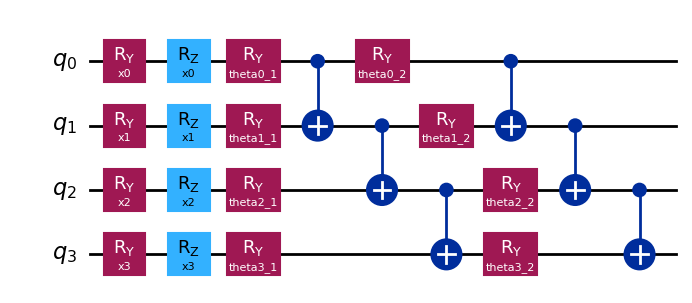

In [9]:
batch_size = 8  # Number of samples per batch
train_dataset = TensorDataset(X_train, y_train)  # Combine features and labels into a dataset

# DataLoader will provide mini-batches and shuffle the data each epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

n_qubits = 4  # 4 features
qc = QuantumCircuit(n_qubits)

# Parameters used for encoding classical features into qubits
x_params = [Parameter(f'x{i}') for i in range(n_qubits)]

# Trainable parameters for the variational layers (two layers)
theta_params = [Parameter(f'theta{i}_1') for i in range(n_qubits)] + \
               [Parameter(f'theta{i}_2') for i in range(n_qubits)]

# Layer 1: Input encoding + variational
for i in range(n_qubits):
    qc.ry(x_params[i], i)  # Encode feature i as rotation around Y-axis
    qc.rz(x_params[i], i)  # Encode feature i as rotation around Z-axis for richer representation
for i in range(n_qubits):
    qc.ry(theta_params[i], i)  # First layer of trainable rotations
for i in range(n_qubits - 1):
    qc.cx(i, i + 1)            # Linear entanglement between qubits with CNOT gates

# Layer 2: Variational only
for i in range(n_qubits, 2*n_qubits):
    qc.ry(theta_params[i], i - n_qubits)  # Second layer of trainable rotations
for i in range(n_qubits - 1):
    qc.cx(i, i + 1)                       # Another layer of linear entanglement


# Measure the Pauli-Z operator on each qubit
# This provides a vector of expectation values (one per qubit) as the quantum output
observables = [SparsePauliOp("I" * i + "Z" + "I" * (n_qubits - 1 - i)) for i in range(n_qubits)]

qc.draw(output='mpl')

In [5]:
backend = AerSimulator(method='statevector')
estimator = EstimatorV2(mode=backend)
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    input_params=x_params,
    weight_params=theta_params,
    observables=observables,
    gradient=gradient
)

qnn_torch = TorchConnector(qnn)

In [ ]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Quantum layer: outputs expectation values from the quantum circuit
        self.qlayer = qnn_torch
        
        # Classical hidden layer: maps quantum outputs to higher-dimensional space
        self.hidden = nn.Linear(n_qubits, 6)  # 6 neurons in hidden layer
        
        # Non-linear activation function
        self.relu = nn.ReLU()
        
        # Output layer: maps hidden layer to 3 classes (Iris species)
        self.fc = nn.Linear(6, 3)  # 3 output neurons, one per class
    
    def forward(self, x):
        # Pass input through quantum layer
        x = self.qlayer(x)
        
        # Pass quantum output through classical hidden layer + activation
        x = self.hidden(x)
        x = self.relu(x)
        
        # Final linear layer to get logits for each class
        x = self.fc(x)
        return x
    
model = HybridModel()                     # Create an instance of the hybrid model
criterion = nn.CrossEntropyLoss()         # Cross-entropy loss for multi-class classification

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
# Adam optimizer with learning rate 0.01

In [7]:
epochs = 25
for epoch in range(epochs):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 3 == 0:
        with torch.no_grad():
            outputs = model(X_train)
            _, preds = torch.max(outputs, 1)
            acc = (preds == y_train).float().mean()
            print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Train Accuracy={acc.item():.4f}")

Epoch 3: Loss=1.0957, Train Accuracy=0.6167
Epoch 6: Loss=0.8568, Train Accuracy=0.7083
Epoch 9: Loss=0.5159, Train Accuracy=0.7917
Epoch 12: Loss=0.3610, Train Accuracy=0.8167
Epoch 15: Loss=0.1988, Train Accuracy=0.9167
Epoch 18: Loss=0.1795, Train Accuracy=0.9667
Epoch 21: Loss=0.0340, Train Accuracy=0.9750
Epoch 24: Loss=0.2411, Train Accuracy=0.9833


In [8]:
with torch.no_grad():
    outputs = model(X_test)
    _, preds = torch.max(outputs, 1)
    acc = (preds == y_test).float().mean()
    print(f"Test Accuracy: {acc.item():.4f}")

Test Accuracy: 1.0000
